In [12]:
%matplotlib inline 
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import sys 
sys.path.append('../code_general/')
sys.path.append('../code_Boyle/')
sys.path.append('../code_general_Finkelsteinlab/')
import read_model_ID as model
import CRISPR_dCas9_binding_curve_Boyle as mastereq
import plotting_Finkelsteinlab as pltData
reload(model);
reload(mastereq);
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()


In [13]:
def calc_clv_curve(parameters, model_id, mismatch_positions, times ,guide_length):
    mat = mastereq.get_master_equation(parameters=parameters, 
                                        mismatch_positions=mismatch_positions, model_id=model_id, guide_length=guide_length)
    
    initial_condition = np.zeros(guide_length+2)
    initial_condition[0] = 1
    initial_condition.T
    
    probs_uncut = np.zeros(len(times))
    
    for i in range(len(times)):
        matrix_exponent = linalg.expm(+mat*times[i])
        probs = matrix_exponent.dot(initial_condition)
        probs_uncut[i] = np.sum(probs)
        
    return probs_uncut

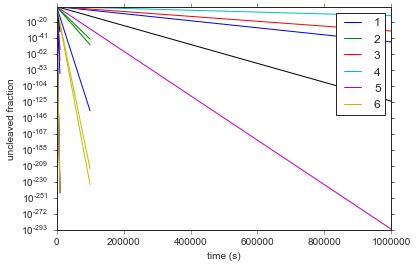

In [14]:
parameters = np.loadtxt('./example-params.txt')
model_id = 'Clv_init_limit_general_energies_v2'
times = [0,1,10,100,1000,10000,100000,1000000]
guide_length = 20

uncut_probs = np.zeros([len(times),20])
plt.figure()

for i in range(20):
    mismatch_positions = [i+1]
    uncut_probs[:,i] = calc_clv_curve(parameters, model_id, mismatch_positions, times, guide_length)
    plt.semilogy(times,uncut_probs[:,i])
    plt.ylabel('uncleaved fraction')
    plt.xlabel('time (s)')
    plt.legend(['1','2','3','4','5','6'])
    



In [15]:
def f(x,k):
    return -k*x

In [16]:
def fit_cleavage_rate(times,probs_uncut,f,treshold = 0.2):
    end = len(times)
    
    #inds = np.arange(end)
    #rejected_inds = inds[probs_uncut<treshold]
    #end = rejected_inds[0]
    
    for i in range(len(times)):
        if probs_uncut[i]<treshold:
            end = i
            break
    
    times = times[0:end]
    probs_uncut = probs_uncut[0:end]
    
    ydata = np.log(probs_uncut)
    k, error = curve_fit(f,times,ydata)
    return k
    

### The effect of having a threshold

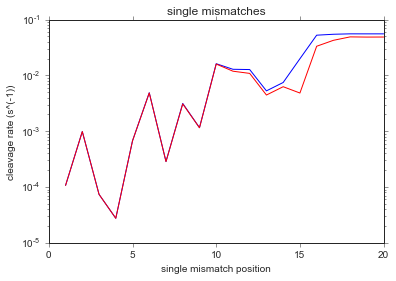

In [17]:
k = np.zeros(20)
k_2 = np.zeros(20)

for i in range(20):
    probs_uncut = uncut_probs[:,i]
    k[i] = fit_cleavage_rate(times,probs_uncut,f,1e-9)[0]

for i in range(20):
    probs_uncut = uncut_probs[:,i]
    k_2[i] = fit_cleavage_rate(times,probs_uncut,f,0.2)[0]

plt.semilogy(range(1,21),k,'b')    
plt.semilogy(range(1,21),k_2,'r')
plt.title('single mismatches')
plt.xlabel('single mismatch position')
plt.ylabel('cleavage rate (s^(-1))')
    

In [18]:
k_matrix = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        uncut_prs = calc_clv_curve(parameters, model_id, mismatch_positions, times, guide_length)
        k_matrix[i-1,j-1] = np.log(fit_cleavage_rate(times,uncut_prs,f,0.2))

## Comparison with data (target E)

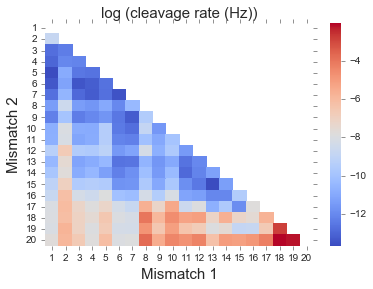

In [19]:
data = pd.read_csv('../data_nucleaseq_Finkelsteinlab/targetE/ECas9_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv')

reload(pltData);
_, double_mut_df = pltData.plot_double_mut_data(data, 'cleavage_rate', 'r', Canonical=True, Ng=20, data_name='log (cleavage rate (Hz))', Plot=True, logplot=True,
                        SaveFigures=False, figure_name='./Figure.pdf')

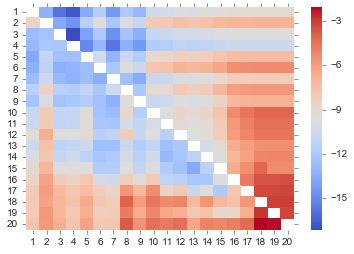

In [20]:
k_df = pd.DataFrame(k_matrix, index=range(1, 21), columns=range(1, 21))
double_mut_df.fillna(0, inplace=True)
combined_df = double_mut_df+k_df

for i in range(1,21):
    combined_df[i].loc[i]=np.nan

sns.heatmap(combined_df, cmap='coolwarm', cbar=True)
